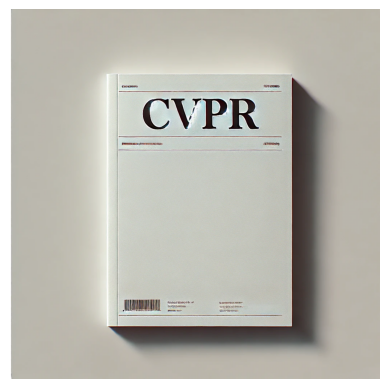

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from diffusers import StableDiffusionPipeline

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, t):
        x = self.down(x)
        x = self.up(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

def linear_noise_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

def add_noise(imgs, t, noise_schedule):
    noise = torch.randn_like(imgs)
    alpha_t = noise_schedule[t].view(-1, 1, 1, 1)
    noisy_imgs = torch.sqrt(alpha_t) * imgs + torch.sqrt(1 - alpha_t) * noise
    return noisy_imgs, noise

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

def train_gan(generator, discriminator, dataloader, noise_schedule, device, epochs=10, lr=1e-4):
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
    criterion_g = nn.MSELoss()
    criterion_d = nn.BCELoss()

    for epoch in range(epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
        for imgs in loop:
            imgs = imgs.to(device)
            t = torch.randint(0, len(noise_schedule), (imgs.size(0),)).to(device)

            noisy_imgs, noise = add_noise(imgs, t, noise_schedule)
            fake_imgs = generator(noisy_imgs, t)

            real_labels = torch.ones(imgs.size(0), 1).to(device)
            fake_labels = torch.zeros(imgs.size(0), 1).to(device)

            optimizer_d.zero_grad()
            real_loss = criterion_d(discriminator(imgs), real_labels)
            fake_loss = criterion_d(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            g_loss = criterion_g(fake_imgs, imgs) + criterion_d(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            optimizer_g.step()

            loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

def generate_with_stable_diffusion(prompt, output_path, device):
    pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
    pipeline.safety_checker = lambda images, **kwargs: (images, False)
    image = pipeline(prompt).images[0]
    image.save(output_path)

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = ImageDataset("path_to_images", transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    timesteps = 1000
    noise_schedule = linear_noise_schedule(timesteps).to(device)
    train_gan(generator, discriminator, dataloader, noise_schedule, device, epochs=10)

    output_path = "Gen.png"
    prompt = "A journal image of CVPR"
    generate_with_stable_diffusion(prompt, output_path, device)
